### Example of Anomaly Detection using Multihead Latent Attention
Instead of using typical normalization, this example use Dynamic Tan from the paper Transformers without Normalization (https://arxiv.org/abs/2503.10622)

In [1]:
import os
import sys
# Move up one directory
os.chdir("..")
path_models_lib = os.path.join(os.getcwd(), "models")
assert os.path.isdir(path_models_lib), "No folder models"
# Add the parent directory to sys.path
sys.path.append(path_models_lib)

In [ ]:

import math
from dataclasses import dataclass
from typing import Tuple, Optional, Literal

import torch
from torch import nn
from torch.optim.lr_scheduler import SequentialLR, LinearLR, CosineAnnealingLR

from einops import rearrange
import torch.optim as optim
import torch.utils.data as data
from functools import partial

import numpy as np
import matplotlib.pyplot as plt

## tqdm for loading bars
# from tqdm import tqdm
from tqdm.notebook import tqdm


plt.set_cmap('cividis')
%matplotlib inline
from matplotlib.colors import to_rgb
import matplotlib
matplotlib.rcParams['lines.linewidth'] = 2.0
import seaborn as sns
sns.reset_orig()

import pytorch_lightning as pl
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint, EarlyStopping
from pytorch_lightning.loggers import TensorBoardLogger


## Torchvision
import torchvision
from torchvision.datasets import CIFAR100
from torchvision import transforms


from models.MLA_DyT.MLA_DyT import ModelArgs, Transformer

In [2]:
# Path to the folder where the datasets are/should be downloaded (e.g. CIFAR10)
DATASET_PATH = "/home/miguel/Desktop/research/data/mla_jax"
# Path to the folder where the pretrained models are saved
CHECKPOINT_PATH = "/home/miguel/Desktop/research/saved_models/mla_deepSeek_reverse_DYT"


# Setting the seed
pl.seed_everything(42)

# Ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print("Device:", device)


Seed set to 42


Device: cuda:0


In [3]:
def plot_attention_maps(input_data, attn_maps, idx=0):
    # 
    if input_data is not None:
        input_data = input_data[idx].detach().cpu().numpy()
    else:
        input_data = np.arange(attn_maps[0][idx].shape[-1])
    attn_maps = [m[idx].detach().cpu().numpy() for m in attn_maps]

    num_heads = attn_maps[0].shape[0]
    num_layers = len(attn_maps)
    seq_len = input_data.shape[0]
    fig_size = 4 if num_heads == 1 else 3
    fig, ax = plt.subplots(num_layers, num_heads, figsize=(num_heads*fig_size, num_layers*fig_size))
    if num_layers == 1:
        ax = [ax]
    if num_heads == 1:
        ax = [[a] for a in ax]
    for row in range(num_layers):
        for column in range(num_heads):
            ax[row][column].imshow(attn_maps[row][column], origin='lower', vmin=0)
            ax[row][column].set_xticks(list(range(seq_len)))
            # ax[row][column].set_xticklabels(input_data.tolist())
            ax[row][column].set_yticks(list(range(seq_len)))
            # ax[row][column].set_yticklabels(input_data.tolist())
            ax[row][column].set_title(f"Layer {row+1}, Head {column+1}")
    fig.subplots_adjust(hspace=0.5)
    plt.show()

In [4]:
# ImageNet statistics
DATA_MEANS = np.array([0.485, 0.456, 0.406])
DATA_STD = np.array([0.229, 0.224, 0.225])
# As torch tensors for later preprocessing
TORCH_DATA_MEANS = torch.from_numpy(DATA_MEANS).view(1,3,1,1)
TORCH_DATA_STD = torch.from_numpy(DATA_STD).view(1,3,1,1)

# Resize to 224x224, and normalize to ImageNet statistic
transform = transforms.Compose([transforms.Resize((224,224)),
                                transforms.ToTensor(),
                                transforms.Normalize(DATA_MEANS, DATA_STD)
                                ])
# Loading the training dataset.
train_set = CIFAR100(root=DATASET_PATH, train=True, transform=transform, download=True)

# Loading the test set
test_set = CIFAR100(root=DATASET_PATH, train=False, transform=transform, download=True)

In [5]:
import os
os.environ["TORCH_HOME"] = CHECKPOINT_PATH
pretrained_model = torchvision.models.resnet34(weights='IMAGENET1K_V1')
# Remove classification layer
# In some models, it is called "fc", others have "classifier"
# Setting both to an empty sequential represents an identity map of the final features.
pretrained_model.fc = nn.Sequential()
pretrained_model.classifier = nn.Sequential()
# To GPU
pretrained_model = pretrained_model.to(device)

# Only eval, no gradient required
pretrained_model.eval()
for p in pretrained_model.parameters():
    p.requires_grad = False

In [6]:
@torch.no_grad()
def extract_features(dataset, save_file):
    if not os.path.isfile(save_file):
        data_loader = data.DataLoader(dataset, batch_size=128, shuffle=False, drop_last=False, num_workers=4)
        extracted_features = []
        for imgs, _ in tqdm(data_loader):
            imgs = imgs.to(device)
            feats = pretrained_model(imgs)
            extracted_features.append(feats)
        extracted_features = torch.cat(extracted_features, dim=0)
        extracted_features = extracted_features.detach().cpu()
        torch.save(extracted_features, save_file)
    else:
        extracted_features = torch.load(save_file)
    return extracted_features

train_feat_file = os.path.join(CHECKPOINT_PATH, "train_set_features.tar")
train_set_feats = extract_features(train_set, train_feat_file)

test_feat_file = os.path.join(CHECKPOINT_PATH, "test_set_features.tar")
test_feats = extract_features(test_set, test_feat_file)

In [7]:
print("Train:", train_set_feats.shape)
print("Test: ", test_feats.shape)

Train: torch.Size([50000, 512])
Test:  torch.Size([10000, 512])


In [8]:
## Split train into train+val
# Get labels from train set
labels = train_set.targets

# Get indices of images per class
labels = torch.LongTensor(labels)
num_labels = labels.max()+1
sorted_indices = torch.argsort(labels).reshape(num_labels, -1) # [classes, num_imgs per class]

# Determine number of validation images per class
num_val_exmps = sorted_indices.shape[1] // 10

# Get image indices for validation and training
val_indices   = sorted_indices[:,:num_val_exmps].reshape(-1)
train_indices = sorted_indices[:,num_val_exmps:].reshape(-1)

# Group corresponding image features and labels
train_feats, train_labels = train_set_feats[train_indices], labels[train_indices]
val_feats,   val_labels   = train_set_feats[val_indices],   labels[val_indices]

In [9]:
class SetAnomalyDataset(data.Dataset):

    def __init__(self, img_feats, labels, set_size=10, train=True):
        """
        Inputs:
            img_feats - Tensor of shape [num_imgs, img_dim]. Represents the high-level features.
            labels - Tensor of shape [num_imgs], containing the class labels for the images
            set_size - Number of elements in a set. N-1 are sampled from one class, and one from another one.
            train - If True, a new set will be sampled every time __getitem__ is called.
        """
        super().__init__()
        self.img_feats = img_feats
        self.labels = labels
        self.set_size = set_size-1 # The set size is here the size of correct images
        self.train = train

        # Tensors with indices of the images per class
        self.num_labels = labels.max()+1
        self.img_idx_by_label = torch.argsort(self.labels).reshape(self.num_labels, -1)

        if not train:
            self.test_sets = self._create_test_sets()


    def _create_test_sets(self):
        # Pre-generates the sets for each image for the test set
        test_sets = []
        num_imgs = self.img_feats.shape[0]
        np.random.seed(42)
        test_sets = [self.sample_img_set(self.labels[idx]) for idx in range(num_imgs)]
        test_sets = torch.stack(test_sets, dim=0)
        return test_sets


    def sample_img_set(self, anomaly_label):
        """
        Samples a new set of images, given the label of the anomaly.
        The sampled images come from a different class than anomaly_label
        """
        # Sample class from 0,...,num_classes-1 while skipping anomaly_label as class
        set_label = np.random.randint(self.num_labels-1)
        if set_label >= anomaly_label:
            set_label += 1

        # Sample images from the class determined above
        img_indices = np.random.choice(self.img_idx_by_label.shape[1], size=self.set_size, replace=False)
        img_indices = self.img_idx_by_label[set_label, img_indices]
        return img_indices


    def __len__(self):
        return self.img_feats.shape[0]


    def __getitem__(self, idx):
        anomaly = self.img_feats[idx]
        if self.train: # If train => sample
            img_indices = self.sample_img_set(self.labels[idx])
        else: # If test => use pre-generated ones
            img_indices = self.test_sets[idx]

        # Concatenate images. The anomaly is always the last image for simplicity
        img_set = torch.cat([self.img_feats[img_indices], anomaly[None]], dim=0)
        indices = torch.cat([img_indices, torch.LongTensor([idx])], dim=0)
        label = img_set.shape[0]-1

        # We return the indices of the images for visualization purpose. "Label" is the index of the anomaly
        return img_set, indices, label

In [10]:
SET_SIZE = 10
test_labels = torch.LongTensor(test_set.targets)
batch_size = 2048

train_anom_dataset = SetAnomalyDataset(train_feats, train_labels, set_size=SET_SIZE, train=True)
val_anom_dataset   = SetAnomalyDataset(val_feats,   val_labels,   set_size=SET_SIZE, train=False)
test_anom_dataset  = SetAnomalyDataset(test_feats,  test_labels,  set_size=SET_SIZE, train=False)

train_anom_loader = data.DataLoader(train_anom_dataset, batch_size=batch_size, shuffle=True,  drop_last=True,  num_workers=0, pin_memory=True)
val_anom_loader   = data.DataLoader(val_anom_dataset,   batch_size=batch_size, shuffle=False, drop_last=False, num_workers=0)
test_anom_loader  = data.DataLoader(test_anom_dataset,  batch_size=batch_size, shuffle=False, drop_last=False, num_workers=0)

<Figure size 640x480 with 0 Axes>

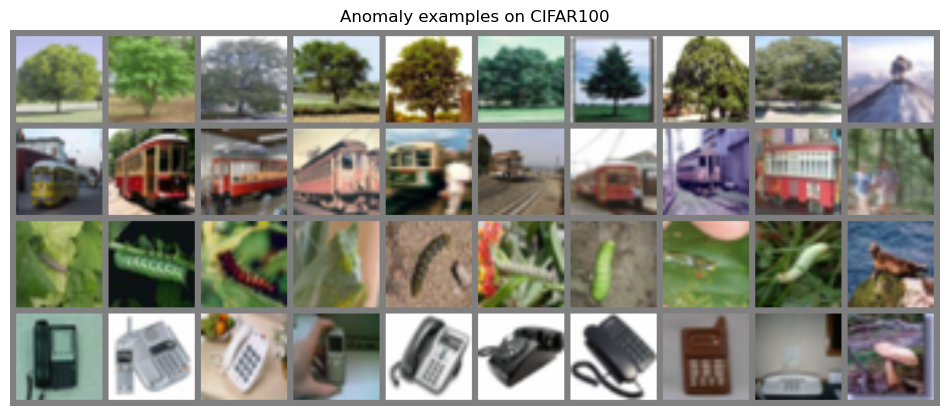

In [11]:
def visualize_exmp(indices, orig_dataset):
    images = [orig_dataset[idx][0] for idx in indices.reshape(-1)]
    images = torch.stack(images, dim=0)
    images = images * TORCH_DATA_STD + TORCH_DATA_MEANS

    img_grid = torchvision.utils.make_grid(images, nrow=SET_SIZE, normalize=True, pad_value=0.5, padding=16)
    img_grid = img_grid.permute(1, 2, 0)

    plt.figure(figsize=(12,8))
    plt.title("Anomaly examples on CIFAR100")
    plt.imshow(img_grid)
    plt.axis('off')
    plt.show()
    plt.close()

_, indices, _ = next(iter(test_anom_loader))
visualize_exmp(indices[:4], test_set)

SET MODEL

In [33]:
class CosineWarmupScheduler(optim.lr_scheduler._LRScheduler):

    def __init__(self, optimizer, warmup, max_iters):
        self.warmup = warmup
        self.max_num_iters = max_iters
        super().__init__(optimizer)

    def get_lr(self):
        lr_factor = self.get_lr_factor(epoch=self.last_epoch)
        return [base_lr * lr_factor for base_lr in self.base_lrs]

    def get_lr_factor(self, epoch):
        lr_factor = 0.5 * (1 + np.cos(np.pi * epoch / self.max_num_iters))
        if epoch <= self.warmup:
            lr_factor *= epoch * 1.0 / self.warmup
        return lr_factor

In [41]:
# from models.dynamicTanh import DyT

class TransformerPredictor(pl.LightningModule):

    def __init__(self, args, **kwargs):
        """
        Inputs:
           
            lr - Learning rate in the optimizer
            warmup - Number of warmup steps. Usually between 50 and 500
            max_iters - Number of maximum iterations the model is trained for. This is needed for the CosineWarmup scheduler
            dropout - Dropout to apply inside the model
            input_dropout - Dropout to apply on the input features
        """
        super().__init__()
         # Save hyperparameters to the checkpoint
        self.save_hyperparameters()

        dropout_out = kwargs.get("dropout_out", 0.1)
        self.warmup = kwargs.get('warmup', 50)
        self.max_iters = kwargs.get('max_iters', 50)
        self.lr = kwargs.get("lr", 1e-6 )

        self.vocab_size = args.vocab_size
        
        self.transformer = Transformer(args=args)
        self.output_net = nn.Sequential(
            nn.Linear(args.dim, args.dim),
            # DyT(num_features = args.dim, alpha_init_value=0.5),
            nn.RMSNorm(args.dim),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout_out),
            nn.Linear(args.dim, args.vocab_size)
        )
    
    def forward(self, x: torch.Tensor, mask=Optional[torch.Tensor], start_pos: int = 0):
        x = self.transformer(tokens = x, mask = mask, start_pos = start_pos)
        x = self.output_net(x)
        return x
    
    @torch.no_grad()
    def get_attention_maps(self, x: torch.Tensor, mask=Optional[torch.Tensor], start_pos: int = 0):
        """
        Function for extracting the attention matrices of the whole Transformer for a single batch.
        Input arguments same as the forward pass.
        """
        attention_maps = self.transformer.get_attention_maps(tokens = x, mask = mask, start_pos = start_pos)
        return attention_maps
    
    def configure_optimizers(self):

        optimizer = optim.AdamW(self.parameters(), lr=self.lr)
        # Apply lr scheduler per step
        lr_scheduler = CosineWarmupScheduler(optimizer,
                                             warmup=self.warmup ,
                                             max_iters=self.max_iters)
         

        return {
            "optimizer": optimizer,
            "lr_scheduler": {
                "scheduler": lr_scheduler,
                "interval": "step"  # Adjust learning rate per step
            }
        }
       
       
    
    def training_step(self, batch, batch_idx):
        raise NotImplementedError

    def validation_step(self, batch, batch_idx):
        raise NotImplementedError

    def test_step(self, batch, batch_idx):
        raise NotImplementedError

In [42]:
class AnomalyPredictor(TransformerPredictor):

    def _calculate_loss(self, batch, mode="train"):
        # Fetch data and transform categories to one-hot vectors
       
        img_sets, _, labels = batch
        preds = self.forward(img_sets, mask=None, start_pos=0) 
        preds = preds.squeeze(dim=-1) # Shape: [Batch_size, set_size]
        loss = nn.functional.cross_entropy(preds, labels) # Softmax/CE over set dimension
        acc = (preds.argmax(dim=-1) == labels).float().mean()
        self.log(f"{mode}_loss", loss)
        self.log(f"{mode}_acc", acc, on_step=False, on_epoch=True)
        return loss, acc
    
    def training_step(self, batch, batch_idx):
        loss, _ = self._calculate_loss(batch, mode="train")
        return loss

    def validation_step(self, batch, batch_idx):
        _ = self._calculate_loss(batch, mode="val")

    def test_step(self, batch, batch_idx):
        _ = self._calculate_loss(batch, mode="test")

In [43]:
def train_anomaly(args, **kwargs):

    max_epochs = kwargs.get("max_epochs", 10)
    # Create a PyTorch Lightning trainer with the generation callback
    root_dir = os.path.join(CHECKPOINT_PATH, "SetAnomalyTask")
    os.makedirs(root_dir, exist_ok=True)
    trainer = pl.Trainer(default_root_dir=root_dir,
                         callbacks=[ModelCheckpoint(save_weights_only=True, mode="max", monitor="val_acc"),
                                    EarlyStopping(monitor='val_acc', patience=20, mode="max")],
                         accelerator="gpu" if str(device).startswith("cuda") else "cpu",
                         devices=1,
                         max_epochs=max_epochs,
                         gradient_clip_val=2)
    trainer.logger._default_hp_metric = None # Optional logging argument that we don't need

    # Check whether pretrained model exists. If yes, load it and skip training
    pretrained_filename = os.path.join(CHECKPOINT_PATH, "SetAnomalyTask.ckpt")
    if os.path.isfile(pretrained_filename):
        print("Found pretrained model, loading...")
        model = AnomalyPredictor.load_from_checkpoint(pretrained_filename)
    else:
       
        model = AnomalyPredictor(args,**kwargs)
        trainer.fit(model, train_anom_loader, val_anom_loader)
        model = AnomalyPredictor.load_from_checkpoint(trainer.checkpoint_callback.best_model_path)

    # Test best model on validation and test set
    train_result = trainer.test(model, train_anom_loader, verbose=False)
    val_result = trainer.test(model, val_anom_loader, verbose=False)
    test_result = trainer.test(model, test_anom_loader, verbose=False)
    result = {"test_acc": test_result[0]["test_acc"], "val_acc": val_result[0]["test_acc"], "train_acc": train_result[0]["test_acc"]}

    model = model.to(device)
    return model, result

In [44]:
args = ModelArgs()
args.input_dim = train_anom_dataset.img_feats.shape[-1]
args.dim = 512
args.inter_dim = 1024
args.n_heads= 4
args.vocab_size = 1
args.n_layers = 4

args.q_lora_rank = 64
args.kv_lora_rank = 64
args.qk_nope_head_dim  = 32
args.qk_rope_head_dim = 32
args.v_head_dim = 64
args.max_batch_size = batch_size
args.dropout = 0.1


train = {
    "dropout_out":0.2,
    "warmup" : 200,
    "max_iters":50,
    "lr": 2.3e-4,
    "max_epochs": 300
    }


anomaly_model, anomaly_result = train_anomaly(args=args, **train)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name        | Type        | Params | Mode 
----------------------------------------------------
0 | transformer | Transformer | 7.5 M  | train
1 | output_net  | Sequential  | 263 K  | train
----------------------------------------------------
7.8 M     Trainable params
0         Non-trainable params
7.8 M     Total params
31.038    Total estimated model params size (MB)
82        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

In [45]:
print(f"Train accuracy: {(100.0*anomaly_result['train_acc']):4.2f}%")
print(f"Val accuracy:   {(100.0*anomaly_result['val_acc']):4.2f}%")
print(f"Test accuracy:  {(100.0*anomaly_result['test_acc']):4.2f}%")

Train accuracy: 98.26%
Val accuracy:   92.74%
Test accuracy:  92.33%


In [46]:
inp_data, indices, labels = next(iter(test_anom_loader))
inp_data = inp_data.to(device)

anomaly_model.eval()

with torch.no_grad():
    preds = anomaly_model.forward(inp_data, mask=None, start_pos=0)
    preds = nn.functional.softmax(preds.squeeze(dim=-1), dim=-1)

    # Permut input data
    permut = np.random.permutation(inp_data.shape[1])
    perm_inp_data = inp_data[:,permut]
    perm_preds = anomaly_model.forward(perm_inp_data, mask=None, start_pos=0)
    perm_preds = nn.functional.softmax(perm_preds.squeeze(dim=-1), dim=-1)

assert (preds[:,permut] - perm_preds).abs().max() < 1e-5, "Predictions are not permutation equivariant"

print("Preds\n", preds[0,permut].cpu().numpy())
print("Permuted preds\n", perm_preds[0].cpu().numpy())

Preds
 [9.9996412e-01 1.2806504e-06 8.5470983e-06 1.5560986e-06 3.2354214e-06
 2.6986465e-06 1.2319971e-06 1.2569930e-05 3.1593067e-06 1.5667307e-06]
Permuted preds
 [9.9996412e-01 1.2806491e-06 8.5470911e-06 1.5560986e-06 3.2354153e-06
 2.6986438e-06 1.2319947e-06 1.2569917e-05 3.1593067e-06 1.5667277e-06]


In [47]:
attention_maps = anomaly_model.get_attention_maps(inp_data, mask=None, start_pos=0)
predictions = preds.argmax(dim=-1)

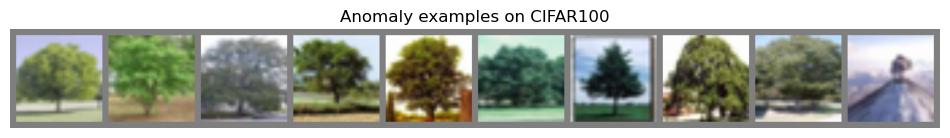

Prediction: 9


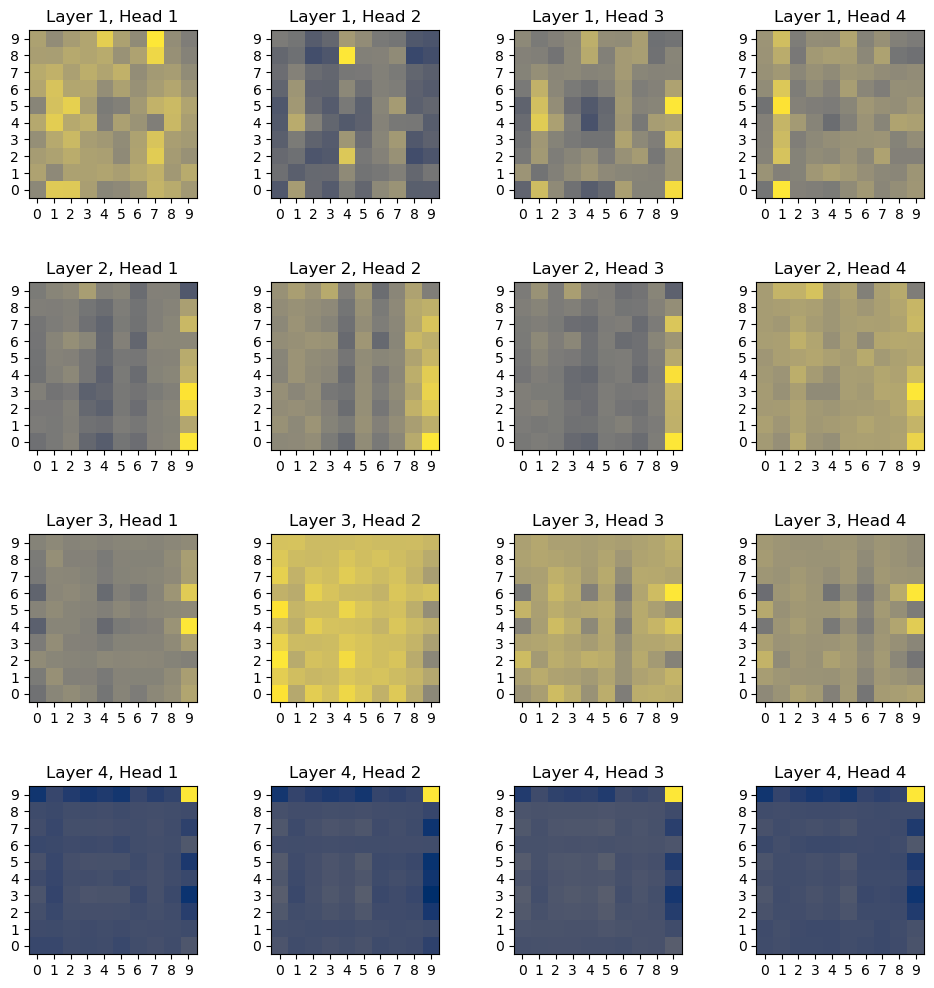

In [48]:
def visualize_prediction(idx):
    visualize_exmp(indices[idx:idx+1], test_set)
    print("Prediction:", predictions[idx].item())
    plot_attention_maps(input_data=None, attn_maps=attention_maps, idx=idx)

visualize_prediction(0)

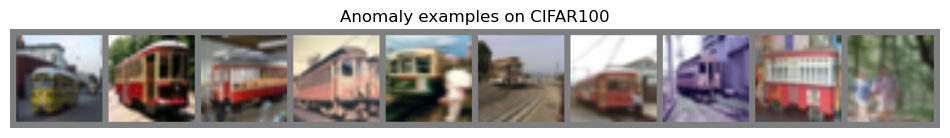

Prediction: 9


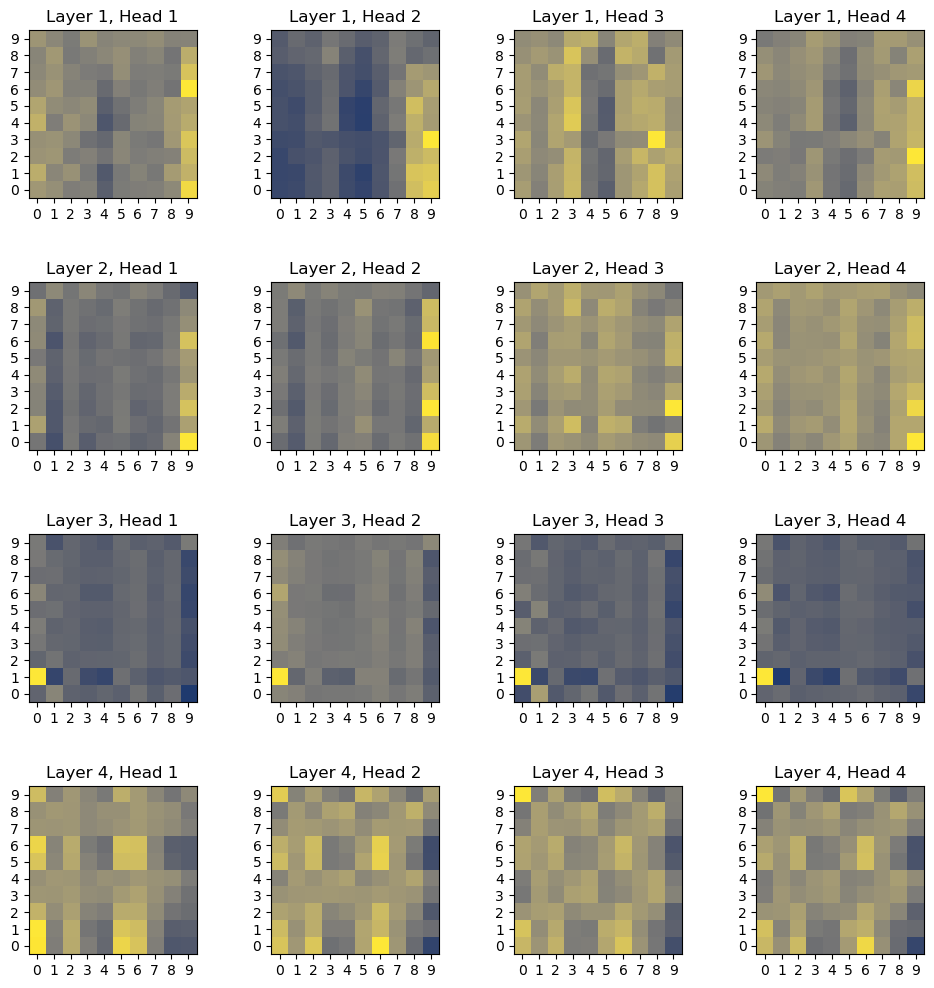

In [49]:
def visualize_prediction(idx):
    visualize_exmp(indices[idx:idx+1], test_set)
    print("Prediction:", predictions[idx].item())
    plot_attention_maps(input_data=None, attn_maps=attention_maps, idx=idx)

visualize_prediction(1)

In [50]:
mistakes = torch.where(predictions != 9)[0].cpu().numpy()
print("Indices with mistake:", mistakes)

Indices with mistake: [  11   24   49   72   92  107  113  115  143  152  159  181  185  196
  221  225  261  267  275  280  302  310  329  347  349  364  373  386
  399  419  456  466  470  475  488  502  506  528  551  590  595  616
  638  642  668  676  678  682  693  694  708  732  742  756  764  773
  782  814  818  822  824  833  851  858  872  879  884  889  948  976
  979  985  993  999 1007 1038 1040 1068 1100 1112 1121 1129 1139 1147
 1151 1161 1190 1199 1230 1232 1253 1281 1292 1299 1309 1310 1330 1339
 1350 1460 1463 1468 1473 1482 1498 1500 1511 1515 1516 1520 1527 1529
 1554 1615 1625 1631 1632 1634 1639 1643 1648 1693 1711 1723 1724 1735
 1739 1752 1754 1757 1765 1777 1793 1798 1799 1802 1805 1807 1815 1838
 1839 1860 1916 1921 1935 1977 1984 1993 2008 2022 2031]


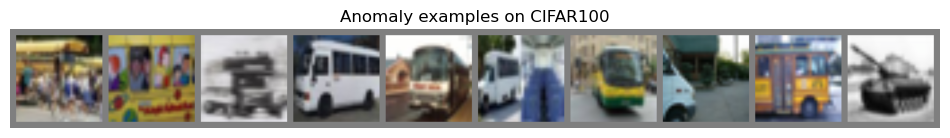

Prediction: 1


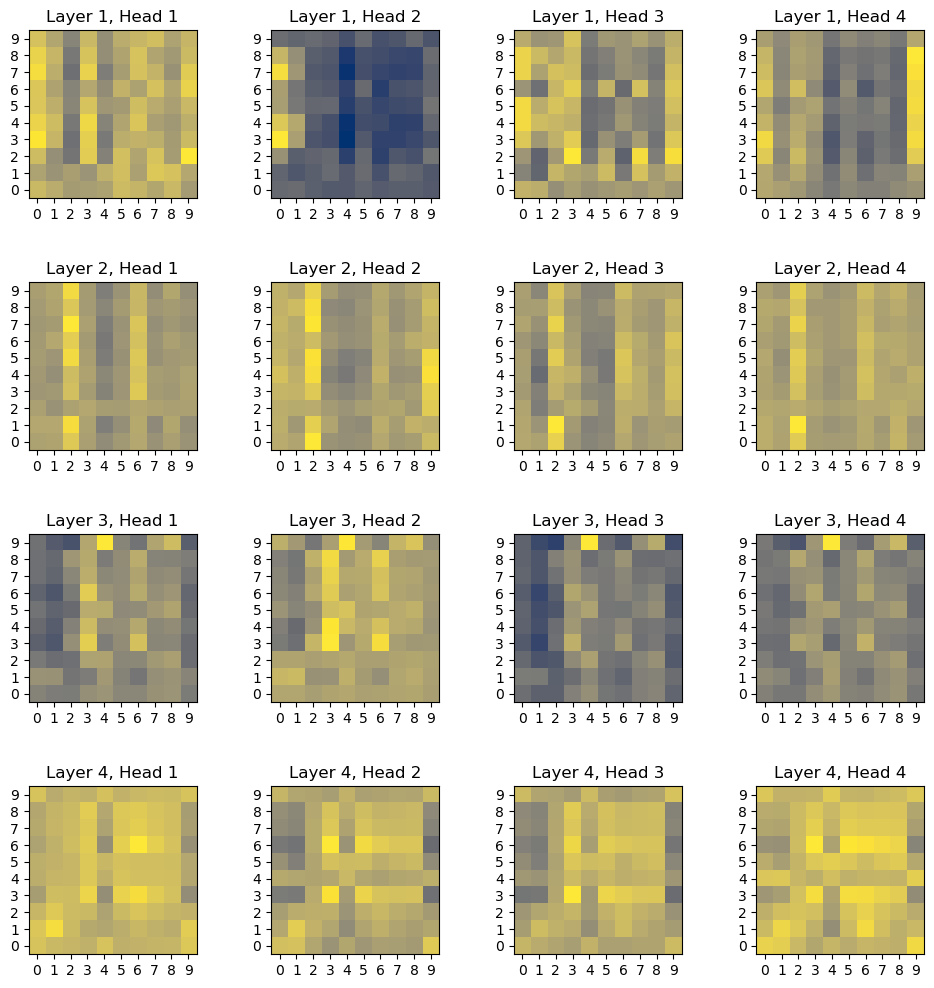

Probabilities:
Image 0: 0.01%
Image 1: 99.90%
Image 2: 0.00%
Image 3: 0.00%
Image 4: 0.00%
Image 5: 0.00%
Image 6: 0.00%
Image 7: 0.00%
Image 8: 0.00%
Image 9: 0.08%


In [51]:
if len(mistakes) >0:
    visualize_prediction(mistakes[-1])
    print("Probabilities:")
    for i, p in enumerate(preds[mistakes[-1]].cpu().numpy()):
        print(f"Image {i}: {100.0*p:4.2f}%")
else:
    print("No mistakes")

TEST LOAD MODEL CREATED BY TORCH LIGTHNING WITH TORCH

In [3]:
import torch
from models.MLA_DyT.MLA_DyT_inference import ModelArgs, Transformer

CHECKPOINT_PATH_FILE = os.path.join(os.path.join(os.path.join(os.path.join( os.path.join(CHECKPOINT_PATH, "SetAnomalyTask"), "lightning_logs"), 'version_2'), "checkpoints"),"epoch=118-step=2499.ckpt") 


CHECKPOINT_PATH_FILE

NameError: name 'CHECKPOINT_PATH' is not defined

Since the model created by torch ligthing just save the weights. It is required to create a model. In this case, the model needs to be defined again.

In [13]:
class TransformerPredictor(nn.Module):

    def __init__(self, args):
        """
        Inputs:
           
            lr - Learning rate in the optimizer
            warmup - Number of warmup steps. Usually between 50 and 500
            max_iters - Number of maximum iterations the model is trained for. This is needed for the CosineWarmup scheduler
    
        """
        super().__init__()
         # Save hyperparameters to the checkpoint
        # self.save_hyperparameters()

        # dropout_out = kwargs.get("dropout_out", 0.1)
        # self.warmup = kwargs.get('warmup', 50)
        # self.max_iters = kwargs.get('max_iters', 50)
        # self.lr = kwargs.get("lr", 1e-6 )

        self.vocab_size = args.vocab_size

   
        
        self.transformer = Transformer(args=args)
        self.output_net = nn.Sequential(
            nn.Linear(args.dim, args.dim),
            nn.RMSNorm(args.dim),
            nn.ReLU(inplace=True),
            nn.Dropout(0.1),
            nn.Linear(args.dim, args.vocab_size)
        )
    
    def forward(self, x: torch.Tensor, mask=Optional[torch.Tensor], start_pos: int = 0):
        x = self.transformer(tokens = x, mask = mask, start_pos = start_pos)
        x = self.output_net(x)
        return x
    
    @torch.no_grad()
    def get_attention_maps(self, x: torch.Tensor, mask=Optional[torch.Tensor], start_pos: int = 0):
        """
        Function for extracting the attention matrices of the whole Transformer for a single batch.
        Input arguments same as the forward pass.
        """
        attention_maps = self.transformer.get_attention_maps(tokens = x, mask = mask, start_pos = start_pos)
        return attention_maps

In [14]:
args = ModelArgs()
args.max_batch_size = batch_size
args.input_dim = train_anom_dataset.img_feats.shape[-1]
args.dim = 512
args.inter_dim = 1024
args.n_heads= 4
args.vocab_size = 1
args.n_layers = 4

args.q_lora_rank = 64
args.kv_lora_rank = 64
args.qk_nope_head_dim  = 32
args.qk_rope_head_dim = 32
args.v_head_dim = 64





model = TransformerPredictor(args=args)

In [15]:
torch.serialization.add_safe_globals([ModelArgs])
# Load the checkpoint with weights_only=False
checkpoint = torch.load(CHECKPOINT_PATH_FILE, weights_only=False)
# Extract the state_dict (model weights)
state_dict = checkpoint['state_dict']

In [16]:
model.load_state_dict(state_dict)
model =  model.to(device)
model.eval()  # Set to evaluation mode

TransformerPredictor(
  (transformer): Transformer(
    (embed): Linear(in_features=512, out_features=512, bias=True)
    (layers): ModuleList(
      (0-3): 4 x Block(
        (attn): MLA(
          (wq_a): Linear(in_features=512, out_features=64, bias=True)
          (q_norm): DyT()
          (wq_b): Linear(in_features=64, out_features=128, bias=True)
          (wkv_a): Linear(in_features=512, out_features=64, bias=True)
          (kv_norm): DyT()
          (wkv_b): Linear(in_features=64, out_features=384, bias=True)
          (wo): Linear(in_features=256, out_features=512, bias=True)
        )
        (ffn): MLP(
          (w1): Linear(in_features=512, out_features=1024, bias=True)
          (w2): Linear(in_features=1024, out_features=512, bias=True)
          (w3): Linear(in_features=512, out_features=1024, bias=True)
        )
        (attn_norm): DyT()
        (ffn_norm): DyT()
      )
    )
  )
  (output_net): Sequential(
    (0): Linear(in_features=512, out_features=512, bias=Tr

Evaluate loaded model

In [17]:
inp_data, indices, labels = next(iter(test_anom_loader))
inp_data = inp_data.to(device)

with torch.no_grad():
    preds = model.forward(inp_data, mask=None, start_pos=0)
    preds = nn.functional.softmax(preds.squeeze(dim=-1), dim=-1)

print(preds)

tensor([[2.7299e-06, 8.6982e-06, 1.2434e-06,  ..., 1.2949e-06, 3.2733e-06,
         9.9996e-01],
        [2.1184e-04, 1.3955e-06, 1.5857e-06,  ..., 1.0796e-06, 4.6560e-06,
         9.9976e-01],
        [4.0558e-08, 2.0362e-08, 9.9702e-08,  ..., 6.2604e-08, 2.2713e-06,
         1.0000e+00],
        ...,
        [3.6472e-07, 2.8798e-07, 3.8925e-07,  ..., 2.9085e-07, 4.1913e-07,
         9.9999e-01],
        [2.0120e-07, 1.2207e-06, 2.2946e-07,  ..., 3.9281e-07, 7.4119e-07,
         1.0000e+00],
        [2.9610e-07, 4.5761e-07, 8.0260e-08,  ..., 6.9406e-08, 4.3241e-03,
         9.9563e-01]], device='cuda:0')


In [18]:
labels[0]

tensor(9)

In [19]:
attention_maps = model.get_attention_maps(inp_data, mask=None, start_pos=0)
predictions = preds.argmax(dim=-1)

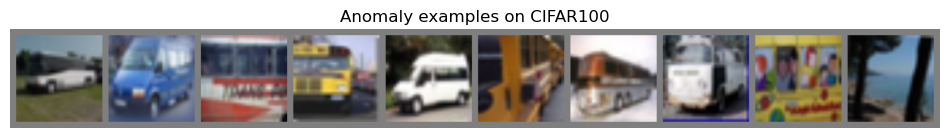

Prediction: 9


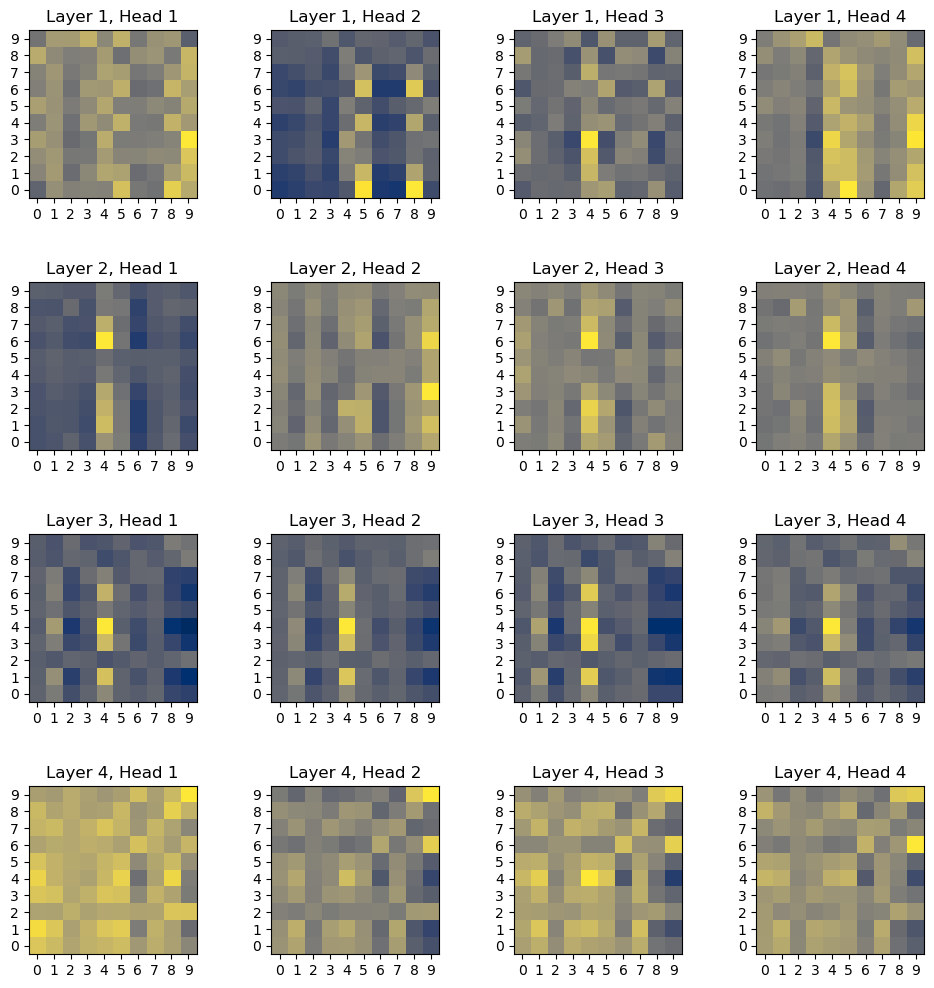

ground thruth tensor(9)


In [20]:
def visualize_prediction(idx):
    visualize_exmp(indices[idx:idx+1], test_set)
    print("Prediction:", predictions[idx].item())
    plot_attention_maps(input_data=None, attn_maps=attention_maps, idx=idx)

visualize_prediction(10)
print("ground thruth",labels[10])

Benchmark Model

In [21]:
import torch
import time

def benchmark_model(model, x, mask=None, n_runs=10, device="cuda"):
    """Benchmark the execution time of a PyTorch model."""

    model.to(device)
    x = x.to(device)
    if mask is not None:
        mask = mask.to(device)

    model.eval()  # Set model to evaluation mode
    
    
    # Warmup (for stable GPU benchmarking)
    with torch.no_grad():
        for _ in range(5):  
            _ = model(x, mask = mask, start_pos=0)

    # Timing execution
    start = time.time()
    with torch.no_grad():
        for _ in range(n_runs):
            _ = model(x, mask = mask, start_pos=0)
    end = time.time()

    avg_time = (end - start) / n_runs
    return avg_time


with absorb -> benchmarks the inference time of a PyTorch model using 10 runs 0.03925447463989258

In [23]:
inp_data, indices, labels = next(iter(test_anom_loader))
inp_data = inp_data.to(device)

b = benchmark_model(model, inp_data , mask=None, n_runs=100,  device="cuda")
print(f"benchmarks the inference time of a PyTorch model using {100} runs {b}")

benchmarks the inference time of a PyTorch model using 100 runs 0.11001065254211426


with naive

In [64]:
inp_data, indices, labels = next(iter(test_anom_loader))
inp_data = inp_data.to(device)

b = benchmark_model(model, inp_data , mask=None, n_runs=100,  device="cuda")
print(f"benchmarks the inference time of a PyTorch model using {100} runs {b}")

benchmarks the inference time of a PyTorch model using 100 runs 0.10883355617523194
